### 🏥 Public Healthcare Organization Data Project – Overview

This project analyzes public healthcare data scraped from HIRA.

**Data Types:**
1. Full HCO (excluding clinics)
2. Clinic-specific data
3. General hospital details

---

**Processing Steps:**

🔹 Step 1 – HCO Full Data (`.../data`)
- Load and merge `.xlsx` files
- Save as `hco_all_df`

🔹 Step 2 – Clinic Data (`.../data/clinic_data`)
- Load and merge `.xlsx` files
- Add department info from filename
- Deduplicate based on hospital name + contact number
- Merge departments per hospital
- Save as `hco_clinic_df` and `clinic_dupl`

🔹 Step 3 – General Hospital Detail (`.../data/hco_detail`)
- Load 2 most recent `.csv` files
- Parse doctor counts into structured columns
- Extract specialty counts by department
- Save as `hco_detail_df`

---

These datasets will be used for further analysis and insights.


In [1]:
import os
import pandas as pd
import re
import warnings
from collections import defaultdict

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from utils.analysis_utils import (
    load_and_merge_files,
    extract_doctor_counts,
    seperate_data,
    extract_region_info,
    get_top_hospitals_by_staff
)
from config.mapping_info import (
    column_mapping,
    department_mapping_snake_case,
    category_mapping,
    province_mapping
)

warnings.filterwarnings('ignore')

# Define folder path
base_dir = os.getcwd()
# fold of HCO data
data_folder = os.path.join(base_dir, "data")
# fold of clinic data
clinic_data_dir = os.path.join(base_dir, "data", "clinic_data")
# fold of hco_detail data
detail_dir = os.path.join(base_dir, "data", "hco_detail")

### Step 1. file load & basic refine

In [2]:
# === load three dataframes ===
hco_all_df = load_and_merge_files(data_folder, file_type="xlsx")
hco_clinic_df = load_and_merge_files(clinic_data_dir, file_type="xlsx")
hco_detail_df = load_and_merge_files(detail_dir, file_type="csv", max_files=2, sort_by_time=True)

📁 Found 10 XLSX file(s) to load:
 - 병원_auto_20250516_1421.xlsx
 - 보건기관_auto_20250516_1421.xlsx
 - 상급종합병원_auto_20250516_1421.xlsx
 - 약국_auto_20250516_1421.xlsx
 - 요양병원_auto_20250516_1421.xlsx
 - 정신병원_auto_20250516_1421.xlsx
 - 조산원_auto_20250516_1421.xlsx
 - 종합병원_auto_20250516_1421.xlsx
 - 치과_auto_20250516_1421.xlsx
 - 한방_auto_20250516_1421.xlsx
✅ Merged shape: (67048, 8)
📁 Found 24 XLSX file(s) to load:
 - 의원_auto_가정의학과_20250516_1945.xlsx
 - 의원_auto_결핵과_20250516_1945.xlsx
 - 의원_auto_내과_20250516_1945.xlsx
 - 의원_auto_마취통증의학과_20250516_1945.xlsx
 - 의원_auto_미표시_20250516_1945.xlsx
 - 의원_auto_병리과_20250516_1945.xlsx
 - 의원_auto_비뇨의학과_20250516_1945.xlsx
 - 의원_auto_산부인과_20250516_1945.xlsx
 - 의원_auto_성형외과_20250516_1945.xlsx
 - 의원_auto_소아청소년과_20250516_1945.xlsx
 - 의원_auto_신경과_20250516_1945.xlsx
 - 의원_auto_신경외과_20250516_1945.xlsx
 - 의원_auto_안과_20250516_1945.xlsx
 - 의원_auto_영상의학과_20250516_1945.xlsx
 - 의원_auto_예방의학과_20250516_1945.xlsx
 - 의원_auto_외과_20250516_1945.xlsx
 - 의원_auto_이비인후과_20250516_1945.xlsx

### Step 2. Data Cleaning Summary
This step prepares the raw scraped datasets for analysis by applying column renaming, deduplication, string parsing, and feature extraction.

**✅ Datasets Cleaned:**  
    1. `hco_all_df` – Full healthcare organization data (excluding clinics)  
    2. `hco_clinic_df` – Clinic-level data  
    3. `hco_detail_df` – Detailed data for general and tertiary hospitals  

---

**📍 Cleaning Tasks by Dataset**

1. hco_all_df & hco_clinic_df
    - Rename columns from Korean to English
    - Extract department info from clinic filenames
    - Remove duplicates by hospital name, phone number, and postal code
    - Merge into a unified dataset `hco_all_merged`
    - Extract `province` and `city` from the full address

2. hco_detail_df
    - Extract doctor counts (doctor, dentist, Korean doctor) using regex
    - Extract hospital category from filename
    - Extract individual specialties and doctor counts from text
    - Dynamically create and fill columns for each department
    - Rename all specialty columns into clean `snake_case` format

These cleaned datasets will be used for descriptive analytics and geospatial visualization in the next steps.


In [3]:
# === 1. Rename Korean columns to English ===
hco_all_df.rename(columns=column_mapping, inplace=True)
hco_clinic_df.rename(columns=column_mapping, inplace=True)
hco_detail_df.rename(columns=column_mapping, inplace=True)

print("✅ Columns renamed:")
print("hco_all:", hco_all_df.columns.tolist())
print("hco_clinic:", hco_clinic_df.columns.tolist())
print("hco_detail:", hco_detail_df.columns.tolist())


# === 2. Extract department info from clinic 'source_file' column ===
seperate_data(hco_clinic_df, column_name_new="department", column_name_raw="source_file", num=3)

# === 3. Remove duplicates in clinic data ===
hco_clinic_df.drop_duplicates(subset=['hospital_name', 'phone', 'postal_code'], keep='first', inplace=True)

# === 4. Merge full dataset (excluding clinic from original) ===
hco_all_merged = pd.concat([hco_all_df, hco_clinic_df], ignore_index=True)
hco_all_merged.drop(columns='source_file', inplace=True)

# === 5. Extract 'province' and 'city' from address using regex ===
hco_all_merged[["province", "city"]] = hco_all_merged["address"].apply(extract_region_info)
hco_all_merged.head()

✅ Columns renamed:
hco_all: ['NO', 'hospital_name', 'category', 'phone', 'postal_code', 'address', 'homepage_address', 'source_file']
hco_clinic: ['NO', 'hospital_name', 'category', 'phone', 'postal_code', 'address', 'homepage_address', 'source_file']
hco_detail: ['NO', 'hospital_name', 'onclick', 'ykiho', 'doctor_info', 'specialties', 'source_file']


,NO,hospital_name,category,phone,postal_code,address,homepage_address,department,province,city
0,1,광안자모병원,병원,051-760-0600,48261,"부산광역시 수영구 수영로 555, (광안동)",NaN,NaN,부산광역시,수영구
1,2,박원욱병원,병원,1544-7582,48298,"부산광역시 수영구 광안로 4, 지하1층,지상5~8층 (광안동, 에스케이뷰상가)",http://www.parkspine.co.kr,NaN,부산광역시,수영구
2,3,메트로적추병원,병원,051-626-0250,48311,"부산광역시 수영구 수영로 390-1, (남천동)",http://www.disc-korea.com/,NaN,부산광역시,수영구
3,4,수영어린이병원,병원,051-753-3579,48243,"부산광역시 수영구 수영로 671, 2층~3층 (광안동)",NaN,NaN,부산광역시,수영구
4,5,한나병원,병원,051-625-2300,48312,"부산광역시 수영구 황령대로481번길 7, (남천동)",NaN,NaN,부산광역시,수영구


In [4]:
hco_all_merged.loc[hco_all_merged['province']=='강원도', 'province']='강원특별자치도'

In [5]:
# === 1. Extract doctor counts from 'doctor_info' column using regex ===
hco_detail_df[['num_doctors', 'num_dentists', 'num_korean_med']] = hco_detail_df['doctor_info'].apply(extract_doctor_counts)

# === 2. Extract hospital type (e.g., tertiary/general) from filename ===
seperate_data(hco_detail_df, column_name_new="category", column_name_raw="source_file", num=4)

# === 3. Get full set of department names from 'specialties' column ===
all_specialties = hco_detail_df["specialties"].dropna().to_list()
dept_set = set()
for row in all_specialties:
    matches = re.findall(r"([^,()]+)\s*\(\d+\)", row)
    dept_set.update([dept.strip() for dept in matches])

# === 4. Initialize new department columns with 0 ===
for dept in dept_set:
    hco_detail_df[dept] = 0

# === 5. Fill in department doctor counts from text pattern ===
for idx, row in hco_detail_df.iterrows():
    if pd.isna(row["specialties"]):
        continue
    matches = re.findall(r"([^,()]+)\s*\((\d+)\)", row["specialties"])
    for dept, count in matches:
        dept = dept.strip()
        if dept in dept_set:
            hco_detail_df.at[idx, dept] = int(count)

# === 6. Rename department columns to snake_case format ===
hco_detail_df.rename(columns=department_mapping_snake_case, inplace=True)

hco_detail_df['total_medical_staff'] = hco_detail_df.iloc[:,7:10].sum(axis=1)
hco_detail_df["category_en"]=hco_detail_df['category'].map(category_mapping)
hco_detail_merged= pd.merge(hco_detail_df, hco_all_merged[['hospital_name','province','city']], how='left', on = 'hospital_name')

print("📌 Total department columns created:", len(dept_set))

📌 Total department columns created: 42


### Step3. Data analysis

#### 3-1) HCO counts

In [6]:
# 1. HCO counts
num_hco = hco_all_merged.groupby('category')['hospital_name'].count().reset_index(name='count')
num_hco['rate(%)'] = round((num_hco['count'] / len(hco_all_merged)) * 100, 2)
num_hco["category_en"] = num_hco["category"].map(category_mapping)

num_hco = num_hco[["category_en", "category", "count", "rate(%)"]]
num_hco.columns = ["category_en", "category_ko", "count", "rate(%)"]

num_hco.sort_values(by='rate(%)',ascending=False)

,category_en,category_ko,count,rate(%)
8,clinic,의원,37196,35.68
6,pharmacy,약국,25305,24.27
13,dental_clinic,치과의원,19223,18.44
15,oriental_clinic,한의원,14796,14.19
4,public_health_center_branch,보건진료소,1895,1.82
0,hospital,병원,1434,1.38
7,nursing_hospital,요양병원,1332,1.28
3,public_health_subcenter,보건지소,1306,1.25
14,oriental_hospital,한방병원,594,0.57
11,general_hospital,종합병원,331,0.32


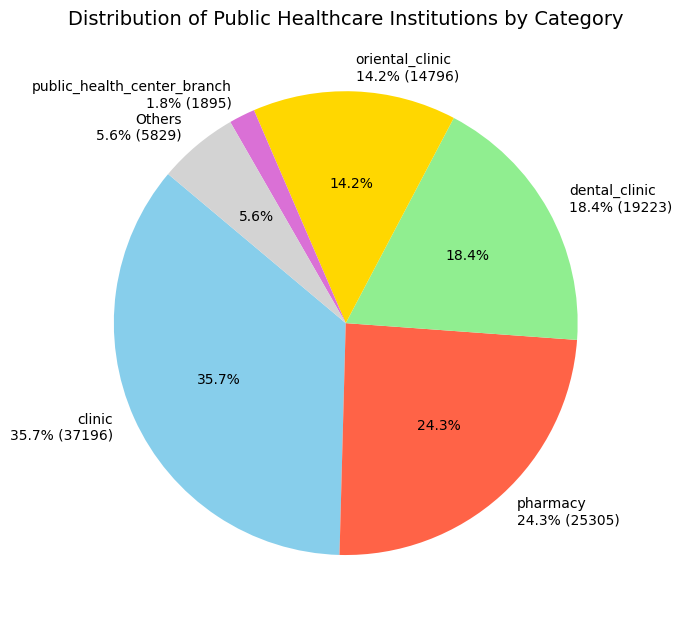

In [7]:
# ✅ 데이터 준비 (예시 DataFrame: num_hco)
df = num_hco.copy()
df = df.sort_values(by="rate(%)", ascending=False)

# ✅ Top 5 + Others 처리
top_n = 5
df_top = df.head(top_n).copy()
df_others = df.iloc[top_n:].copy()

# ✅ Others 합산
others = pd.DataFrame({
    "category_en": ["Others"],
    "category_ko": ["기타"],
    "count": [df_others["count"].sum()],
    "rate(%)": [df_others["rate(%)"].sum()]
})

# ✅ 최종 데이터프레임
df_final = pd.concat([df_top, others], ignore_index=True)

# ✅ 라벨 생성: rate + count 함께 표시
df_final["label"] = df_final.apply(lambda row: f'{row["category_en"]}\n{row["rate(%)"]:.1f}% ({int(row["count"])})', axis=1)

# ✅ 색상 지정 (pharmacy 강조)
colors = []
for cat in df_final["category_en"]:
    if cat == "pharmacy":
        colors.append("tomato")  # 강조 색
    elif cat == "clinic":
        colors.append("skyblue")
    elif cat == "dental_clinic":
        colors.append("lightgreen")
    elif cat == "oriental_clinic":
        colors.append("gold")
    elif cat == "public_health_center_branch":
        colors.append("orchid")
    else:
        colors.append("lightgray")  # Others

# ✅ 파이차트 그리기
plt.figure(figsize=(7, 10))
wedges, texts, autotexts = plt.pie(
    df_final["count"],
    labels=df_final["label"],
    colors=colors,
    startangle=140,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",  # 너무 작은 조각은 표시 생략
    textprops={"fontsize": 10}
)

plt.title("Distribution of Public Healthcare Institutions by Category", fontsize=14)
plt.tight_layout()
plt.show()


#### 3-2) 시도별 병원수

In [8]:
# 3. 시도별 병원 수
province_counts = hco_all_merged.groupby("province")['hospital_name'].count().reset_index(name='count')
total_hco = province_counts['count'].sum()
province_counts['rate(%)'] = (province_counts['count'] / total_hco * 100).round(2)
province_counts['province_ko'] = province_counts['province']
province_counts['province_en'] = province_counts['province'].map(province_mapping)
province_counts = province_counts[['province_en','province_ko', 'count', 'rate(%)']]
province_counts=province_counts.sort_values(by='count', ascending=False)
province_counts

,province_en,province_ko,count,rate(%)
8,Seoul,서울특별시,25149,24.13
1,Gyeonggi,경기도,23782,22.81
7,Busan,부산광역시,7323,7.02
2,Gyeongnam,경상남도,5648,5.42
5,Daegu,대구광역시,5611,5.38
11,Incheon,인천광역시,5157,4.95
3,Gyeongbuk,경상북도,4543,4.36
13,Jeonbuk,전북특별자치도,3941,3.78
15,Chungnam,충청남도,3873,3.72
12,Jeonnam,전라남도,3480,3.34


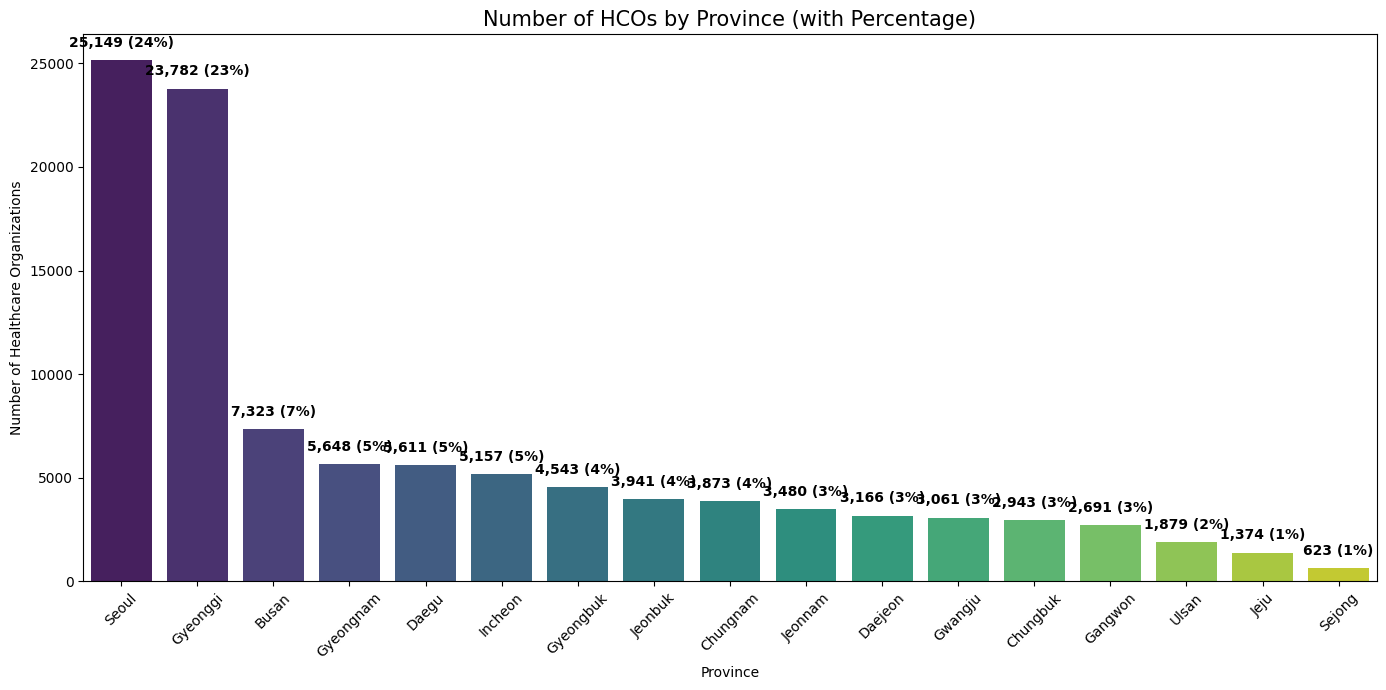

In [9]:
# Set style
plt.figure(figsize=(14, 7))
barplot = sns.barplot(
    data=province_counts.sort_values(by="count", ascending=False),
    x='province_en',
    y='count',
    palette='viridis'
)

# Add labels on top of bars
for i, row in province_counts.sort_values(by="count", ascending=False).reset_index().iterrows():
    barplot.text(
        i,
        row["count"] + 500,  # bar 위 살짝 띄우기
        f"{row['count']:,} ({row['rate(%)']:.0f}%)",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Axis & Title settings
plt.xticks(rotation=45)
plt.title("Number of HCOs by Province (with Percentage)", fontsize=15)
plt.ylabel("Number of Healthcare Organizations")
plt.xlabel("Province")
plt.tight_layout()
plt.show()

#### 3-3) 상급종합병원과 종합병원의 데이터 집계

In [13]:
# Top 10
hco_staff= hco_detail_merged[['hospital_name','num_doctors','num_dentists', 'num_korean_med', 'total_medical_staff','category']]

print("\nTop 10 of tertiary_hospital (num_medical_staff)")
get_top_hospitals_by_staff(hco_staff, "상급종합병원", 10)


Top 10 of tertiary_hospital (num_medical_staff)


,hospital_name,num_doctors,num_dentists,num_korean_med,total_medical_staff,category
380,재단법인아산사회복지재단 서울아산병원,1083.0,40.0,0.0,1123.0,상급종합병원
389,서울대학교병원,957.0,1.0,0.0,958.0,상급종합병원
391,연세대학교의과대학세브란스병원,956.0,1.0,0.0,957.0,상급종합병원
379,삼성서울병원,919.0,18.0,0.0,937.0,상급종합병원
382,학교법인가톨릭학원가톨릭대학교서울성모병원,628.0,32.0,0.0,660.0,상급종합병원
376,분당서울대학교병원,600.0,30.0,0.0,630.0,상급종합병원
374,아주대학교병원,433.0,36.0,0.0,469.0,상급종합병원
388,학교법인 고려중앙학원 고려대학교의과대학부속병원(안암병원),375.0,25.0,0.0,400.0,상급종합병원
381,연세대학교의과대학 강남세브란스병원,333.0,52.0,0.0,385.0,상급종합병원
386,고려대학교의과대학부속구로병원,342.0,33.0,0.0,375.0,상급종합병원


In [12]:
print("\nTop 10 of general_hospital (num_medical_staff)")
get_top_hospitals_by_staff(hco_staff, "종합병원", 10)


Top 10 of general_hospital (num_medical_staff)


,hospital_name,num_doctors,num_dentists,num_korean_med,total_medical_staff,category
233,차의과학대학교분당차병원,325.0,5.0,2.0,332.0,종합병원
262,서울특별시보라매병원,261.0,10.0,0.0,271.0,종합병원
307,이화여자대학교의과대학부속서울병원,260.0,8.0,0.0,268.0,종합병원
180,순천향대학교부속 천안병원,244.0,5.0,0.0,249.0,종합병원
246,한국보훈복지의료공단 중앙보훈병원,171.0,69.0,1.0,241.0,종합병원
12,인제대학교 해운대백병원,233.0,7.0,0.0,240.0,종합병원
336,국민건강보험공단일산병원,203.0,30.0,0.0,233.0,종합병원
260,순천향대학교 부속 서울병원,227.0,5.0,0.0,232.0,종합병원
204,연세대학교 의과대학 용인세브란스병원,224.0,6.0,0.0,230.0,종합병원
311,가톨릭대학교 은평성모병원,225.0,4.0,0.0,229.0,종합병원


In [14]:
summary_df_staff = pd.pivot_table(hco_detail_merged,
               index = 'category_en',
               values = ['num_doctors','num_dentists', 'num_korean_med', 'total_medical_staff'],
               aggfunc='mean').round(2).reset_index()


summary_df_hco = hco_detail_merged['category_en'].value_counts().reset_index(name='num_hospitals')

summary_df = summary_df_hco.merge(summary_df_staff, how='left')

summary_df

,category_en,num_hospitals,num_dentists,num_doctors,num_korean_med,total_medical_staff
0,general_hospital,350,1.85,58.76,0.11,60.55
1,tertiary_hospital,47,11.51,321.64,0.00,333.15


#### 지역별 전공의 진료과목 시각화

In [30]:
dept_snack_case_list = hco_detail_merged.iloc[0:0,11:-4].columns.tolist()

In [41]:
province_grouped = hco_detail_merged.groupby('province')[dept_snack_case_list].mean().reset_index().round(2)
hco_counts_tri = hco_detail_merged[hco_detail_merged['category']=='상급종합병원'].groupby('province')['category_en'].count().reset_index(name='num_tertiary_hospital').round(2)
hco_counts_gen = hco_detail_merged[hco_detail_merged['category']=='종합병원'].groupby('province')['category_en'].count().reset_index(name='num_general_hospital').round(2)

region_specialty_df = pd.merge(hco_counts_gen, hco_counts_tri, how='left', on='province').merge(province_grouped, how='left',on='province').fillna(0)

region_specialty_df['province_ko'] = region_specialty_df['province']
region_specialty_df['province_en'] = region_specialty_df['province'].map(province_mapping)

region_specialty_df.sort_values(by='num_general_hospital',ascending=False, inplace=True)

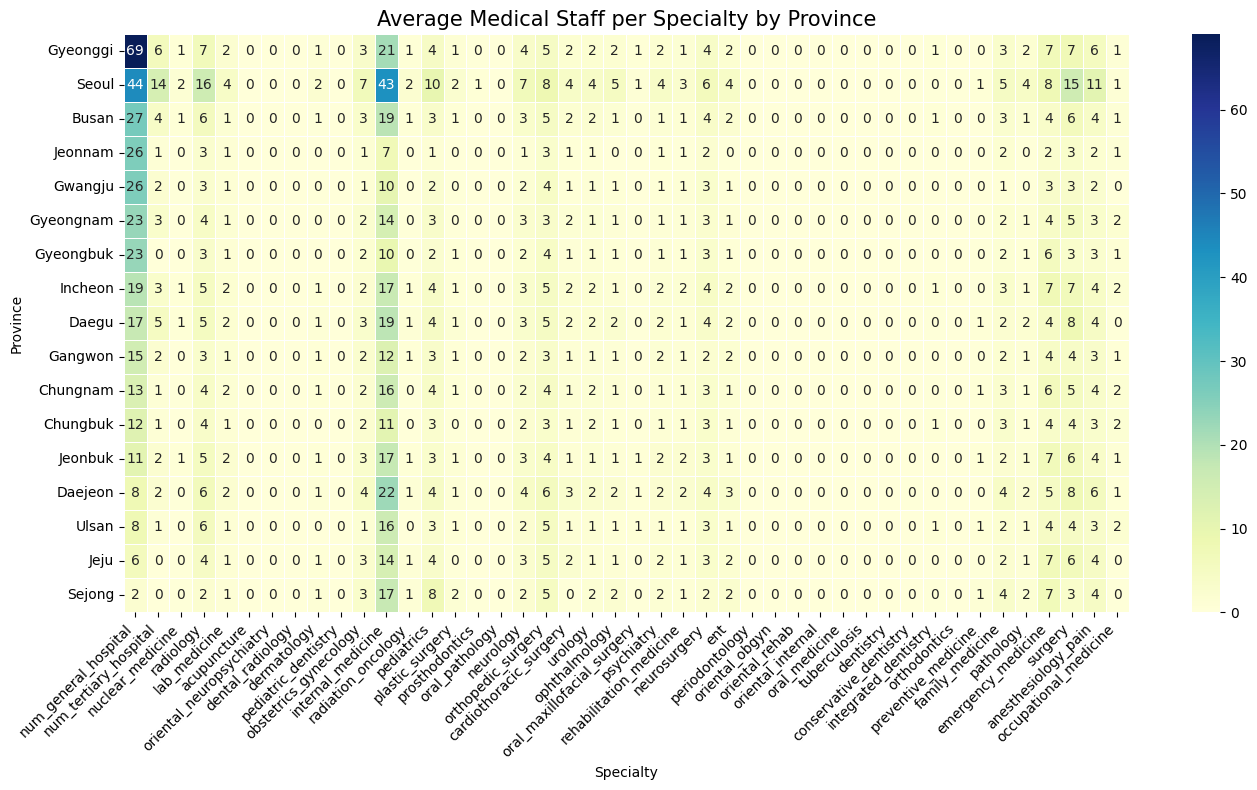

In [53]:
# 시각화 대상: 전문진료과목 컬럼만 추출
specialty_cols = region_specialty_df.columns[1:-2]  # num_병원 이후의 컬럼들
region_heatmap_df = region_specialty_df.set_index('province_en')[specialty_cols]

# 히트맵 그리기
plt.figure(figsize=(14, 8))
sns.heatmap(region_heatmap_df, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)

plt.title("Average Medical Staff per Specialty by Province", fontsize=15)
plt.xlabel("Specialty")
plt.ylabel("Province")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [69]:
specialty_cols = (region_specialty_df.iloc[:,3:-2].sum(axis=0).sort_values(ascending=False).head(10).index.tolist())

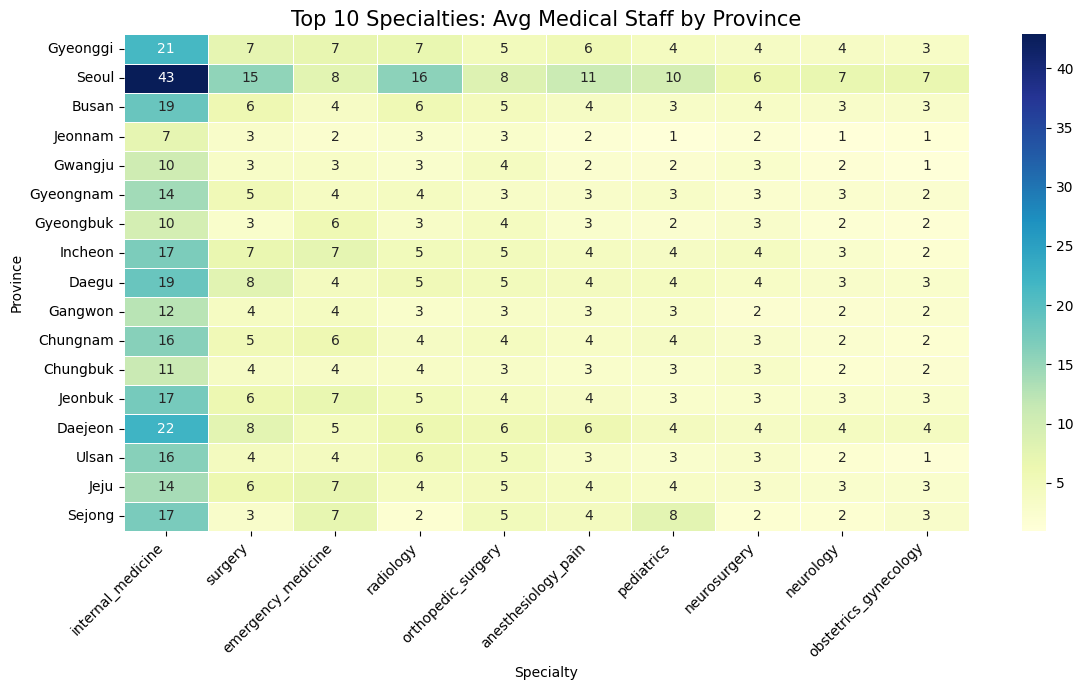

In [71]:
# 시각화 대상: 전문진료과목 컬럼만 추출
top_province = region_specialty_df#.head(10)
top_region_heatmap_df = top_province.set_index('province_en')[specialty_cols]

# 히트맵 다시 그리기
plt.figure(figsize=(12, 7))
sns.heatmap(top_region_heatmap_df, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)
plt.title("Top 10 Specialties: Avg Medical Staff by Province", fontsize=15)
plt.xlabel("Specialty")
plt.ylabel("Province")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


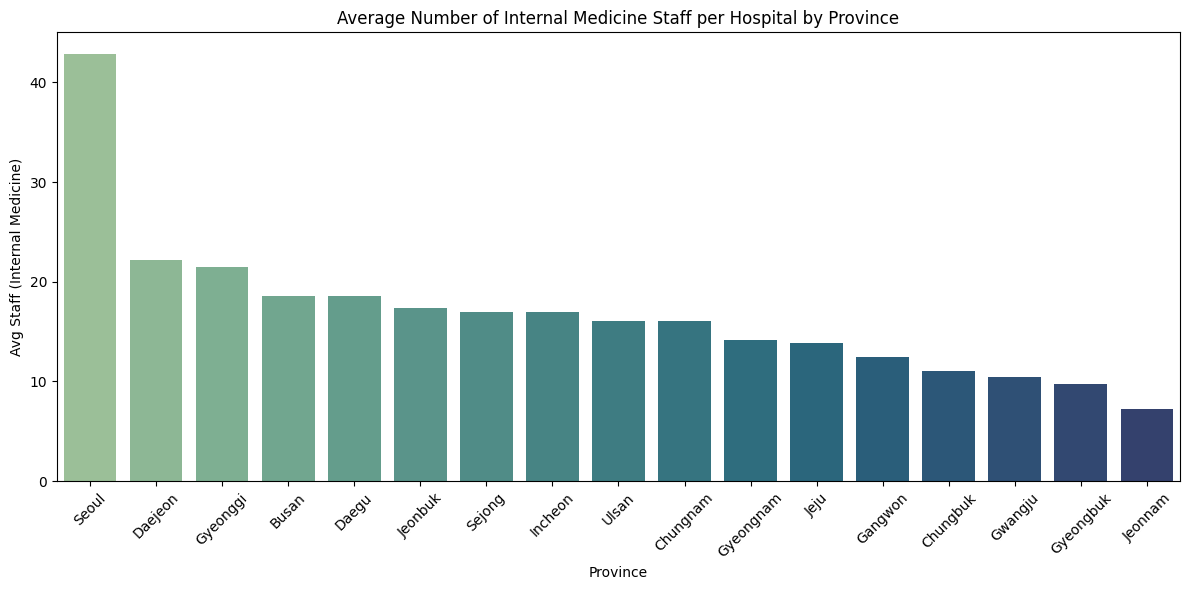

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=region_specialty_df.sort_values(by='internal_medicine', ascending=False),
            x='province_en', y='internal_medicine', palette='crest')
plt.title("Average Number of Internal Medicine Staff per Hospital by Province")
plt.ylabel("Avg Staff (Internal Medicine)")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()